# Welcome to My Notebook

In [1]:
# Kaggle environment comes with many python libraries preinstalled
from IPython.display import display
import numpy as np      # linear algebra
import pandas as pd     # data processing
import matplotlib.pyplot as plt   # used for data visualization 
import seaborn as sns             # used for data visualization
import warnings
import time
# ignore all warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [2]:
input_dir = '../input/titanic'
train_dir = '../input/titanic/train.csv'
test_dir = '../input/titanic/test.csv'

In [3]:
train_data = pd.read_csv(train_dir)
print(train_data.shape)
train_data.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Here we see various features like *Passangerid*, *Pclass*, *Name* and so on

### A few things to note here:

1) **PassengerId** is of no value when it comes to predicting the label

2) Our target label is **Survived**

3) **Name** column can be dropped since we can't predict if a person survives based on their name

4) The **Ticket** column can be dropped since I doubt any effort in finding a correlation between the random string values and the target label is worth it.

# Preprocessing and Exploration

Preprocessing is a vital for the success of any algorithm. Its like the marination we do before cooking a great dish

Preprocessing heavily depends on the algorithm you are using as well as the data itself.
XGboost, Random Forest are some of the golden algorithms that don't require much preprocssing 

However we need to convert the string data into categorical features.

Also in the columns like Pclass, we need to convert it into categorical feature. Having continuous numerical representation might lead the algorithm to misinterpret that the higher value has higher weight eg Pclass 3 has more weight than Pclass 1 when in reality they might just be the opposite.

In [4]:
"""
only choosing the features that seem useful 

note when the no of features are high pd.drop can be used to remove the columns inplace
instead of creating a new dataframe

"""
traindf = train_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']]
traindf.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [5]:
# Checking the unique values and their frequency
traindf.Sex.replace({"male": "0", "female": "1"}, inplace=True)
print("All the Values in Embarked column along with their frequency\n")
display(traindf.Embarked.value_counts())
print("\nAll the Values in Parch column along with their frequency\n")
display(traindf.Parch.value_counts())
print("\nAll the Values in SibSp column along with their frequency\n")
display(traindf.SibSp.value_counts())
traindf.head()

All the Values in Embarked column along with their frequency



S    644
C    168
Q     77
Name: Embarked, dtype: int64


All the Values in Parch column along with their frequency



0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64


All the Values in SibSp column along with their frequency



0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,0,22.0,1,0,7.2500,S,0
1,1,1,38.0,1,0,71.2833,C,1
2,3,1,26.0,0,0,7.9250,S,1
3,1,1,35.0,1,0,53.1000,S,1
4,3,0,35.0,0,0,8.0500,S,0


In [6]:
# Finding the nan values in the dataframe
print(traindf.isna().sum())
traindf.dropna(inplace = True)
print()
print(traindf.isna().sum())
# Usually most algoritms need us to fix mixing values by either imputing them or dropping the
# rows or columns with missing values with pd.dropna() or similar functions.
# Luckily xgboost can handle missing values :) but for simplicity I dropped the columns with nans

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Survived      0
dtype: int64

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


In [7]:
# Converting to categorical and getting dummy variables
df_Embarked = pd.get_dummies(traindf.Embarked)
traindf = pd.concat([traindf, df_Embarked], axis = 1)
traindf.drop(['Embarked'], axis = 1, inplace = True)
traindf.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,C,Q,S
0,3,0,22.0,1,0,7.2500,0,0,0,1
1,1,1,38.0,1,0,71.2833,1,1,0,0
2,3,1,26.0,0,0,7.9250,1,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,1
4,3,0,35.0,0,0,8.0500,0,0,0,1


In [8]:
# Convert the datatype of Sex column from object to int
traindf = traindf.astype({'Sex': int})
print(traindf.dtypes)

Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Survived      int64
C             uint8
Q             uint8
S             uint8
dtype: object


In [9]:
traindf.corr()

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,C,Q,S
Pclass,1.000000,-0.150826,-0.365902,0.065187,0.023666,-0.552893,-0.356462,-0.279194,0.131989,0.197831
Sex,-0.150826,1.000000,-0.099037,0.106296,0.249543,0.182457,0.536762,0.103611,0.027256,-0.109078
Age,-0.365902,-0.099037,1.000000,-0.307351,-0.187896,0.093143,-0.082446,0.038268,-0.021693,-0.025431
SibSp,0.065187,0.106296,-0.307351,1.000000,0.383338,0.139860,-0.015523,-0.046227,0.051331,0.018968
Parch,0.023666,0.249543,-0.187896,0.383338,1.000000,0.206624,0.095265,-0.009523,-0.009417,0.013259
Fare,-0.552893,0.182457,0.093143,0.139860,0.206624,1.000000,0.266100,0.301337,-0.062346,-0.250994
Survived,-0.356462,0.536762,-0.082446,-0.015523,0.095265,0.266100,1.000000,0.195673,-0.048966,-0.159015
C,-0.279194,0.103611,0.038268,-0.046227,-0.009523,0.301337,0.195673,1.000000,-0.095623,-0.884986
Q,0.131989,0.027256,-0.021693,0.051331,-0.009417,-0.062346,-0.048966,-0.095623,1.000000,-0.378859
S,0.197831,-0.109078,-0.025431,0.018968,0.013259,-0.250994,-0.159015,-0.884986,-0.378859,1.000000


### The table above shows the correlation between various features

The diagonal is always 1 since every feature has perfect corelation with itself. In layman terms if any object is compard to itself, it is always a perfect match. When represented as a function x = y, if x increases by 1 so does y and so on. if x = -y, the magnitude of correlation is 1 but the sign is negetive since if x increases in +ve direction, y increases in negetive direction and vice versa

We have to focus on the **Survived** row and column as it is our target variable.
The greater the absolute value of the table either (positive or negetive), the greater the correlation; that is if its closer to 1 or -1, the more the dependency of the output on the given feature and the closer it is to 0, the lower the effect of the feature on the output.

From the table we can see that **Sex** and **Pclass** have some effect on the output

Don't worry this table is just to give an idea of which feature might be useful.
We can plot graphs to get a better understanding.

## Plot the Data

Number of Survivors:  288
Number of People who didn't survive :  424


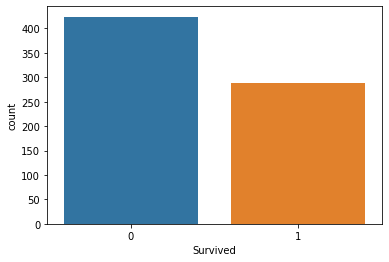

In [10]:
# number of survivors vs no of people who didn't survive

ax = sns.countplot(traindf.Survived,label="Count")      
Dead, Survived = traindf.Survived.value_counts()
print('Number of Survivors: ',Survived)
print('Number of People who didn\'t survive : ',Dead)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Pclass'),
  Text(1, 0, 'Sex'),
  Text(2, 0, 'Age'),
  Text(3, 0, 'SibSp'),
  Text(4, 0, 'Parch'),
  Text(5, 0, 'Fare'),
  Text(6, 0, 'C'),
  Text(7, 0, 'Q'),
  Text(8, 0, 'S')])

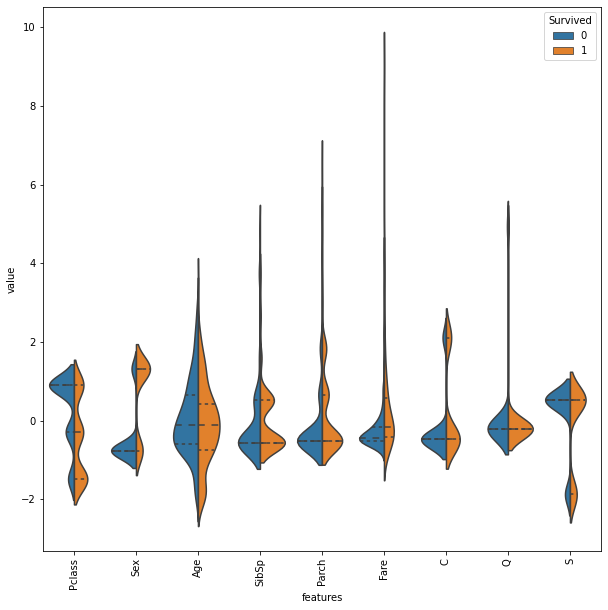

In [11]:
plotY = traindf.Survived
plotX = traindf.drop('Survived', axis = 1)
plotX_Std = (plotX - plotX.mean()) / (plotX.std()) # standardization
plotX_Std = pd.concat([plotX_Std, plotY], axis = 1)
plot_data = pd.melt(plotX_Std,id_vars="Survived",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="Survived", data=plot_data,split=True, inner="quart")
plt.xticks(rotation=90)

### Now how do we interpret the data?
What we are looking for is peaks and how close they are to each other.
If they are close that means its not a good way to distribute the data
If they are far away, it means that they are good features to predict the output. Also the size of the peak is an indicator of the magnitude of the target value distribution.

Here we see in ***PClass*** the peak of the blue section is high when its value is 3(note the value in the graph is around 1 as we applied standardization which squishes all values between 1 and -1). The blue section represents non survivors. The graph tells when a person has a 3rd class ticket, the person is less likely survive as indicated by the blue peak. It makes sense intuitively as high class passangers are more likely to get priority when it comes to rescue operations.

Similarly in the ***Sex*** section we see a clear distinctions in the peaks which indicate the male population has a far higher mortality rate than the females.

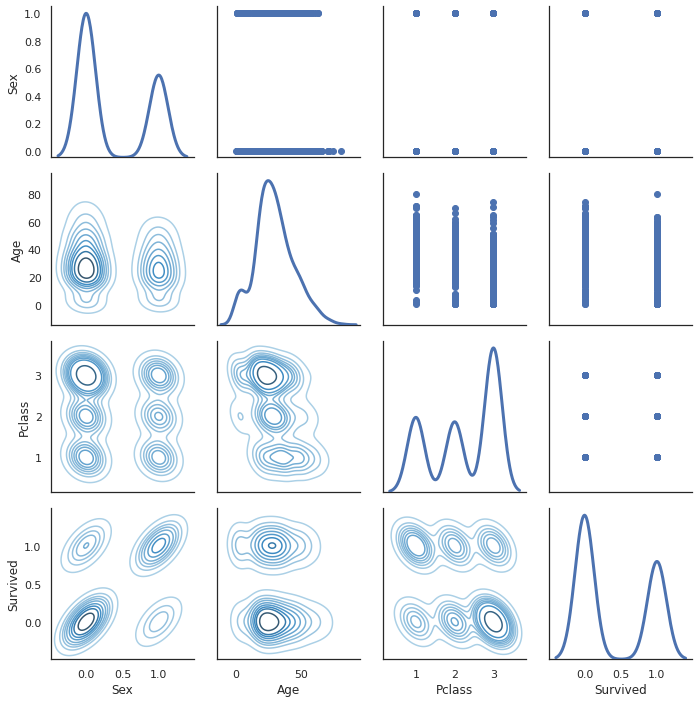

In [12]:
"""
As we have a pretty good idea about how sex affects the target variable, 
we can study the effect of other features on the output
"""
sns.set(style="white")
plotdf = traindf.loc[:,['Sex','Age', 'Pclass','Survived']]
g = sns.PairGrid(plotdf, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

### Interpretation

The Diagonal Graphs simply represnt the distribution of the class that is how many entities belong to which subclass. For example in the 16th graph **Survived** X **Survived** we see the peak at 0 is higher which indicates the number of people who didn't survive is higher.

The graph **Survived** X **Age** gives us a similar intuition. The lower circular figure is more dense between 25 to 45 which corresponds to a 0 in **Survived**. It means that people in this age group are more likely to die than any other age group which makes sense cause elderly people and children are given more preference when it comes to rescue operations.

The graph of **Survived** X **Pclass** gives us the same inference that we previously derived. A 3rd class passanger is more likely to die than a first class one. It is represented my dense concentric ciruclar pattern corresponding to 0 in **Survived** and 3 in **Pclass**

The graph **Survived** X **Sex** shows women are more likely to survive than men

## Additional Resources 
https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15

https://matplotlib.org/stable/tutorials/index.html

https://www.geeksforgeeks.org/python-seaborn-tutorial/
